# Training models with PRONTO datasets
- multiclass classification: failure
    - feature: sensor datas, alarm
    - class: failure
- multiclass classification: alarm
    - feature: sensor datas
    - class: alarms
- HTM, CNN, FNN, Random Forest, Support Vector machines, Logistic Regression, voted ensemble selection

In [ ]:
from google.colab import drive
import pandas as pd
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn import svm
import matplotlib.pyplot as plt
import statistics


## Mount Google drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/My\ Drive/Colab\ Notebooks/summer_coop/pronto

/content/drive/My Drive/Colab Notebooks/summer_coop/pronto


In [ ]:
ls

archive.zip                            pronto_cnn_alarm_architecture.png
best_ann_alarm_model.h5                pronto_cnn_failure_architecture.png
best_ann_failure_model.h5              PRONTO_failure_result.png
best_cnn_alarm_model.h5                PRONTO_get_data.ipynb
best_cnn_failure_model.h5              PRONTO_result.tsv
input_oh1.npy                          Testday2_merged.csv
pronto_ann1_failure_architecture.png   Testday2_merged.png
pronto_ann2_alarm_architecture.png     Testday3_merged.csv
PRONTO_benchmark_case_study/           Testday4_merged.csv
pronto_cnn11_failure_architecture.png


## Data Preprocessing

### Get data

In [ ]:
day2 = pd.read_csv('./Testday2_merged.csv')
day3 = pd.read_csv('./Testday3_merged.csv')
day4 = pd.read_csv('./Testday4_merged.csv')

In [ ]:
print(day2.describe())
print(day3.describe())
print(day4.describe())

             FIC301        FIC302  ...  Water.level.valve  water.tank.level
count  12420.000000  12420.000000  ...       12420.000000      12420.000000
mean       0.028824      0.053462  ...           5.625045          1.438565
std        0.167320      0.224962  ...           3.704148          0.010241
min        0.000000      0.000000  ...           0.000000          1.393454
25%        0.000000      0.000000  ...           2.593196          1.439275
50%        0.000000      0.000000  ...           7.064692          1.441777
75%        0.000000      0.000000  ...           8.093972          1.444006
max        1.000000      1.000000  ...          47.400379          1.448196

[8 rows x 29 columns]
             FIC301        FIC302  ...  Water.level.valve  water.tank.level
count  21300.000000  21300.000000  ...       21300.000000      21300.000000
mean       0.081502      0.073286  ...           4.427603          1.425289
std        0.273611      0.260612  ...           4.459148        

### Check NaN value
- no NaN value

In [ ]:
print(day2.isnull().values.any())
print(day3.isnull().values.any())
print(day4.isnull().values.any())

False
False
False


### Merge the data
- inner join to prevent NaN value
- LI505: only in testday3
- LI502: only in testday2 and testday4
- → exclude LI502, LI505

In [ ]:
data_arr = pd.concat([day2, day3, day4], axis = 0, ignore_index=True, join = 'inner')

In [ ]:
data_arr.head()

,FIC301,FIC302,LI405,PT312,VC303,VC401,VC403,VC404,VC405,VC406,VLV303,AirIn,Air.T,Air.P,WaterIn,Water.T,Water.Density,Mixture.zone.P,riser.outlet.P,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level,Fault
0,0,0,1,0,0,0,0,0,0,0,0,121.053597,15.68166,1.301107,0.096309,23.748079,997.596497,1.240097,1.025907,1.027175,0.000491,0.064845,1.005916,25.092310,62.243111,98.642677,2.257356,1.443121,Normal
1,0,0,1,0,0,0,0,0,0,0,0,120.982101,15.68156,1.298735,0.096320,23.745350,997.596619,1.236252,1.027934,1.027277,0.000483,0.095639,1.006192,25.099390,62.235279,98.644371,2.278575,1.443152,Normal
2,0,0,1,0,0,0,0,0,0,0,0,120.864098,15.68147,1.296362,0.096331,23.742620,997.596619,1.240946,1.035563,1.028881,0.000476,0.095639,1.006467,25.106461,62.227440,98.646057,2.299793,1.443183,Normal
3,0,0,1,0,0,0,0,0,0,0,0,120.746002,15.68138,1.301659,0.096342,23.739889,997.596680,1.238252,1.030079,1.028640,0.000468,0.076789,1.006743,25.113529,62.219608,98.647758,2.321012,1.443214,Normal
4,0,0,1,0,0,0,0,0,0,0,0,120.627998,15.68129,1.299090,0.096354,23.737160,997.596680,1.231918,1.026742,1.028400,0.000461,0.076789,1.006743,25.120600,62.262520,98.649452,2.399387,1.443244,Normal


In [ ]:
data_arr.isnull().values.any()

False

In [ ]:
data_arr.describe()

,FIC301,FIC302,LI405,PT312,VC303,VC401,VC403,VC404,VC405,VC406,VLV303,AirIn,Air.T,Air.P,WaterIn,Water.T,Water.Density,Mixture.zone.P,riser.outlet.P,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level
count,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.0,45420.0,45420.0,45420.0,45420.0,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000
mean,0.071180,0.062241,0.679018,0.163804,0.002576,0.0,0.0,0.0,0.0,0.0,0.000044,120.244962,17.579774,1.754868,0.545004,23.426888,996.696162,1.494589,1.109878,1.019045,3.358363,0.559113,0.997311,22.352009,61.782958,98.623634,9.275199,1.426527
std,0.257128,0.241596,0.466859,0.370102,0.050689,0.0,0.0,0.0,0.0,0.0,0.006636,42.618978,1.086663,0.947866,0.751641,1.960987,1.209464,0.333043,0.165797,0.030180,5.135456,0.567385,0.029712,7.369957,1.457677,0.173581,11.556427,0.012909
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,16.019110,15.107760,0.607549,-0.007640,18.197229,990.697327,0.997974,0.820029,0.845333,0.000000,-4.607517,0.822942,0.030689,49.623772,97.675377,0.000000,1.388638
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,118.268898,16.704707,1.281357,0.098050,23.249670,996.235275,1.242075,1.014582,1.017692,0.000414,0.070511,0.996003,20.038310,61.755878,98.549589,2.283776,1.419087
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,120.583950,17.850080,1.507924,0.495899,23.752180,996.706360,1.416394,1.037709,1.021233,0.043302,0.397561,0.999314,25.058850,61.981190,98.664036,6.556579,1.425808
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,149.015793,18.249603,1.736749,0.500112,24.663151,997.657013,1.519924,1.153582,1.024938,6.983966,0.942655,1.002923,27.315350,62.153648,98.712509,8.254080,1.439326
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,210.018494,20.017281,7.269874,3.673232,26.674419,999.480774,3.923677,3.183747,1.328773,43.850960,2.840868,1.307652,34.459080,75.759613,99.930847,56.039059,1.448196


In [ ]:
data_arr.columns

Index(['FIC301', 'FIC302', 'LI405', 'PT312', 'VC303', 'VC401', 'VC403',
       'VC404', 'VC405', 'VC406', 'VLV303', 'AirIn', 'Air.T', 'Air.P',
       'WaterIn', 'Water.T', 'Water.Density', 'Mixture.zone.P',
       'riser.outlet.P', 'P.topsep', 'FR.topsep.gas', 'FR.topsep.liquid',
       'P_3phase', 'Air.Valve', 'Water.level', 'Water.coalescer',
       'Water.level.valve', 'water.tank.level', 'Fault'],
      dtype='object')

## Multiclass Classification: failure
- feature: FIC301 ~ water.tank.level (alarm, sensor values)
- Class(total 5 classes)
    - 0: normal
    - 1: Air blockage
    - 2: Air leakage
    - 3: Diverted flow
    - 4: Slugging

In [ ]:
input_arr1 = data_arr.loc[:, 'FIC301':'water.tank.level']
target_arr1 = data_arr.loc[:, 'Fault']

In [ ]:
data_arr['Fault'].unique()

array(['Normal', 'Air blockage', 'Air leakage', 'Diverted flow',
       'Slugging'], dtype=object)

In [ ]:
target_arr1.unique()

array(['Normal', 'Air blockage', 'Air leakage', 'Diverted flow',
       'Slugging'], dtype=object)

change Fault values to int

In [ ]:
target_arr1[target_arr1 == 'Normal'] = 0
target_arr1[target_arr1 == 'Air blockage'] = 1
target_arr1[target_arr1 == 'Air leakage'] = 2
target_arr1[target_arr1 == 'Diverted flow'] = 3
target_arr1[target_arr1 == 'Slugging'] = 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

In [ ]:
target_arr1.unique()

array([0, 1, 2, 3, 4], dtype=object)

In [ ]:
!ls

archive.zip			      pronto_cnn11_failure_architecture.png
best_ann_alarm_model.h5		      pronto_cnn_alarm_architecture.png
best_ann_failure_model.h5	      pronto_cnn_failure_architecture.png
best_cnn_alarm_model.h5		      PRONTO_failure_result.png
best_cnn_failure_model.h5	      PRONTO_get_data.ipynb
input_oh1.npy			      PRONTO_result.tsv
input_oh1_numpynpy.npy		      Testday2_merged.csv
pronto_ann1_failure_architecture.png  Testday2_merged.png
pronto_ann2_alarm_architecture.png    Testday3_merged.csv
PRONTO_benchmark_case_study	      Testday4_merged.csv


In [ ]:
input_data1 = input_arr1.to_numpy()
target_data1 = target_arr1.to_numpy(dtype = np.int)

In [ ]:
input_data1 = input_data1.reshape(-1, 28, 1)
print(input_data1.shape)

(45420, 28, 1)


### Split train data and test data

In [ ]:
train_input1, test_input1, train_target1, test_target1 = train_test_split(input_data1, target_data1, test_size = 0.2)
print(train_input1.shape, test_input1.shape, train_target1.shape, test_target1.shape)

(36336, 28, 1) (9084, 28, 1) (36336,) (9084,)


### Normalize the data

In [ ]:
mean = train_input1.mean()
std = train_input1.std()

train_scaled1 = (train_input1 - mean) / std
test_scaled1 = (test_input1 - mean) / std

### Split train data and validation data

In [ ]:
train_scaled1, val_scaled1, train_target1, val_target1 = train_test_split(train_scaled1, train_target1, test_size = 0.2)
print(train_scaled1.shape, val_scaled1.shape, train_target1.shape, val_target1.shape)

(29068, 28, 1) (7268, 28, 1) (29068,) (7268,)


In [ ]:
print(train_input1[:, :100, 0])

[[ 0.          0.          1.         ... 98.33541107 40.85972977
   1.39510405]
 [ 0.          0.          0.         ... 98.62212372  8.19772625
   1.44240797]
 [ 0.          0.          0.         ... 98.46906281 32.48007965
   1.40956199]
 ...
 [ 0.          0.          1.         ... 98.49568939  8.36553287
   1.42387199]
 [ 0.          0.          0.         ... 98.65579224  7.89612913
   1.44022906]
 [ 0.          0.          0.         ... 98.80213165  4.03325605
   1.43020201]]


### Train Model
- HTM, CNN, ANN, Random Forest, Support Vector machines, Logistic Regression, voted ensemble selection

#### CNN

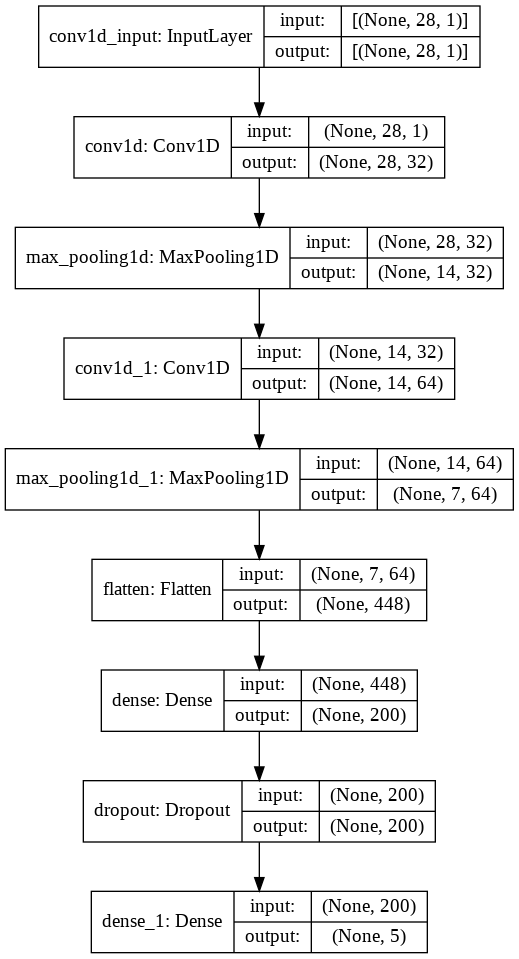

In [ ]:
cnn1 = keras.Sequential()
cnn1.add(keras.layers.Conv1D(32, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (28, 1)))
cnn1.add(keras.layers.MaxPooling1D(2))
cnn1.add(keras.layers.Conv1D(64, kernel_size = 2, padding = 'same', activation = 'relu'))
cnn1.add(keras.layers.MaxPooling1D(2))
cnn1.add(keras.layers.Flatten())
cnn1.add(keras.layers.Dense(200, activation = 'relu'))
cnn1.add(keras.layers.Dropout(0.4))
cnn1.add(keras.layers.Dense(5, activation = 'softmax'))
keras.utils.plot_model(cnn1, to_file = './pronto_cnn_failure_architecture.png', show_shapes = True)

In [ ]:
cnn1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_cnn_failure_model.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
cnn1_history = cnn1.fit(train_scaled1, train_target1, epochs = 100, validation_data = (val_scaled1, val_target1), callbacks = [checkpoint_cb, earlystopping_cb])

Epoch 1/100
909/909 [==============================] - 6s 5ms/step - loss: 1.0685 - accuracy: 0.5100 - val_loss: 0.8235 - val_accuracy: 0.6308
Epoch 2/100
909/909 [==============================] - 4s 5ms/step - loss: 0.7985 - accuracy: 0.6405 - val_loss: 0.7309 - val_accuracy: 0.8121
Epoch 3/100
909/909 [==============================] - 5s 5ms/step - loss: 0.6668 - accuracy: 0.7350 - val_loss: 0.5404 - val_accuracy: 0.8492
Epoch 4/100
909/909 [==============================] - 5s 5ms/step - loss: 0.5050 - accuracy: 0.8317 - val_loss: 0.3966 - val_accuracy: 0.8653
Epoch 5/100
909/909 [==============================] - 4s 5ms/step - loss: 0.4177 - accuracy: 0.8618 - val_loss: 0.3700 - val_accuracy: 0.8675
Epoch 6/100
909/909 [==============================] - 5s 5ms/step - loss: 0.3901 - accuracy: 0.8718 - val_loss: 0.3982 - val_accuracy: 0.8514
Epoch 7/100
909/909 [==============================] - 5s 5ms/step - loss: 0.3729 - accuracy: 0.8761 - val_loss: 0.3799 - val_accuracy: 0.8632

#### ANN

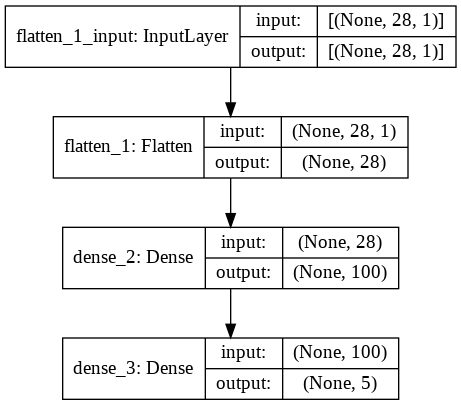

In [ ]:
ann1 = keras.Sequential()
ann1.add(keras.layers.Flatten(input_shape = (28, 1)))
ann1.add(keras.layers.Dense(100, activation = 'relu'))
ann1.add(keras.layers.Dense(5, activation = 'softmax'))
keras.utils.plot_model(ann1, to_file = './pronto_ann1_failure_architecture.png', show_shapes = True)


In [ ]:
ann1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_ann_failure_model.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
ann1_history = ann1.fit(train_scaled1, train_target1, epochs = 100, validation_data = (val_scaled1, val_target1), callbacks = [checkpoint_cb, earlystopping_cb])

Epoch 1/100
909/909 [==============================] - 2s 2ms/step - loss: 1.3641 - accuracy: 0.3958 - val_loss: 1.1922 - val_accuracy: 0.5338
Epoch 2/100
909/909 [==============================] - 2s 2ms/step - loss: 1.0986 - accuracy: 0.5444 - val_loss: 1.0047 - val_accuracy: 0.5809
Epoch 3/100
909/909 [==============================] - 1s 2ms/step - loss: 0.9664 - accuracy: 0.5785 - val_loss: 0.9240 - val_accuracy: 0.5903
Epoch 4/100
909/909 [==============================] - 2s 2ms/step - loss: 0.9115 - accuracy: 0.5916 - val_loss: 0.8944 - val_accuracy: 0.5929
Epoch 5/100
909/909 [==============================] - 2s 2ms/step - loss: 0.8803 - accuracy: 0.6046 - val_loss: 0.8696 - val_accuracy: 0.5871
Epoch 6/100
909/909 [==============================] - 2s 2ms/step - loss: 0.8571 - accuracy: 0.6138 - val_loss: 0.8444 - val_accuracy: 0.6128
Epoch 7/100
909/909 [==============================] - 1s 2ms/step - loss: 0.8403 - accuracy: 0.6202 - val_loss: 0.8393 - val_accuracy: 0.6037

### Reshape the data for Machine Learning

In [ ]:
train_scaled11 = train_scaled1.reshape(-1, 28)
print(train_scaled11.shape)

(29068, 28)


#### Random Forest

In [ ]:
rf1 = RandomForestClassifier(n_jobs=-1, oob_score=True)
print(rf1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)


In [ ]:
rf1.fit(train_scaled11, train_target1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
rf1_train = rf1.score(train_scaled11, train_target1)

In [ ]:
val_scaled11 = val_scaled1.reshape(-1, 28)

In [ ]:
rf1_val = rf1.score(val_scaled11, val_target1)

#### Support Vector machine

In [ ]:
svm1 = svm.LinearSVC(C = 1.0, max_iter = 10000)
svm1.fit(train_scaled11, train_target1)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
svm1_train = svm1.score(train_scaled11, train_target1)

In [ ]:
svm1_val = svm1.score(val_scaled11, val_target1)

In [ ]:
svm12 = svm.SVC(kernel = 'rbf', gamma = 0.7, C = 1.0)
svm12.fit(train_scaled11, train_target1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.7, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm12_train = svm12.score(train_scaled11, train_target1)
svm12_val = svm12.score(val_scaled11, val_target1)
print(svm12_train, svm12_val)

0.6857024907114353 0.6810676940011007


In [ ]:
svm13 = svm.SVC(kernel = 'poly', degree = 3, gamma = 'auto', C = 1.0)
svm13.fit(train_scaled11, train_target1)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm13_train = svm13.score(train_scaled11, train_target1)
svm13_val = svm13.score(val_scaled11, val_target1)
print(svm13_train, svm13_val)

0.5354685564882344 0.5379746835443038


#### Logistic Regression
- using cross_validate does not make any difference in accuracy

In [ ]:
lr1 = LogisticRegression(max_iter = 1000)
splitter = StratifiedKFold(n_splits= 5)
lr1_score = cross_validate(lr1, train_scaled11, train_target1, cv = splitter, return_train_score = True, return_estimator= True)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print(np.mean(lr1_score['train_score']), np.mean(lr1_score['test_score']))

0.7141529817653017 0.7140498465208907


In [ ]:
lr11 = LogisticRegression(max_iter = 1000)
lr11.fit(train_scaled11, train_target1)
lr11_train = lr11.score(train_scaled11, train_target1)
lr11_val = lr11.score(val_scaled11, val_target1)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(lr11_train, lr11_val)

0.7378560616485482 0.7301871216290589


#### Voted ensemble selection

## Multiclass Classification: alarm
- feature: AirIn ~ water.tank.level (sensor data)
- class: FIC301 ~ VLV303 (alarm)
- → total 12 classes

In [ ]:
target_arr2 = data_arr.loc[:,'FIC301':'VLV303']

In [ ]:
target_arr2.describe()

,FIC301,FIC302,LI405,PT312,VC303,VC401,VC403,VC404,VC405,VC406,VLV303
count,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.0,45420.0,45420.0,45420.0,45420.0,45420.000000
mean,0.071180,0.062241,0.679018,0.163804,0.002576,0.0,0.0,0.0,0.0,0.0,0.000044
std,0.257128,0.241596,0.466859,0.370102,0.050689,0.0,0.0,0.0,0.0,0.0,0.006636
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
75%,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000


In [ ]:
target_arr2 = target_arr2.to_numpy(dtype = np.int)

### Apply Priority Encoder to target values
- 0: no alarm
- 1: FIC301
- 2: FIC302
- 3: LI405
- 4: PT312
- 5: VC303
- 6: VC401
- 7: VC403
- 8: VC404
- 9: VC405
- 10: VC406
- 11: VLC303

In [ ]:
target_int = []
one_hot = 0
for x in target_arr2:
    for i in range(len(target_arr2[0])):
        # failure situation
        if(x[i] == 1):
            target_int.append(i + 1)
            one_hot = 1
            break # priority encoder
    # normal situation
    if(one_hot == 0):
        target_int.append(0)
    one_hot = 0
        
target_int = np.array(target_int, dtype = np.int)

In [ ]:
target_arr2[:10]

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
target_int[:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
print(target_int.max(), target_int.min(), target_int.mean())

11 0 2.901298987230295


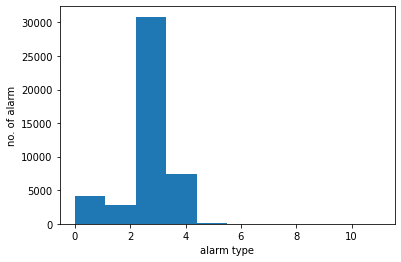

In [ ]:
plt.hist(target_int)
plt.xlabel('alarm type')
plt.ylabel('no. of alarm')
plt.show()

### Split feature

In [ ]:
input_arr2 = data_arr.loc[:, 'AirIn':'water.tank.level']
input_arr2.describe()

,AirIn,Air.T,Air.P,WaterIn,Water.T,Water.Density,Mixture.zone.P,riser.outlet.P,P.topsep,FR.topsep.gas,FR.topsep.liquid,P_3phase,Air.Valve,Water.level,Water.coalescer,Water.level.valve,water.tank.level
count,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000,45420.000000
mean,120.244962,17.579774,1.754868,0.545004,23.426888,996.696162,1.494589,1.109878,1.019045,3.358363,0.559113,0.997311,22.352009,61.782958,98.623634,9.275199,1.426527
std,42.618978,1.086663,0.947866,0.751641,1.960987,1.209464,0.333043,0.165797,0.030180,5.135456,0.567385,0.029712,7.369957,1.457677,0.173581,11.556427,0.012909
min,16.019110,15.107760,0.607549,-0.007640,18.197229,990.697327,0.997974,0.820029,0.845333,0.000000,-4.607517,0.822942,0.030689,49.623772,97.675377,0.000000,1.388638
25%,118.268898,16.704707,1.281357,0.098050,23.249670,996.235275,1.242075,1.014582,1.017692,0.000414,0.070511,0.996003,20.038310,61.755878,98.549589,2.283776,1.419087
50%,120.583950,17.850080,1.507924,0.495899,23.752180,996.706360,1.416394,1.037709,1.021233,0.043302,0.397561,0.999314,25.058850,61.981190,98.664036,6.556579,1.425808
75%,149.015793,18.249603,1.736749,0.500112,24.663151,997.657013,1.519924,1.153582,1.024938,6.983966,0.942655,1.002923,27.315350,62.153648,98.712509,8.254080,1.439326
max,210.018494,20.017281,7.269874,3.673232,26.674419,999.480774,3.923677,3.183747,1.328773,43.850960,2.840868,1.307652,34.459080,75.759613,99.930847,56.039059,1.448196


In [ ]:
input_arr2 = input_arr2.to_numpy(dtype = np.float32)

### Split train data and test data

In [ ]:
train_input2, test_input2, train_target2, test_target2 = train_test_split(input_arr2, target_int, test_size = 0.2)
print(train_input2.shape, test_input2.shape, train_target2.shape, test_target2.shape)

(36336, 17) (9084, 17) (36336,) (9084,)


### Normalize the data

In [ ]:
mean = train_input2.mean()
std = train_input2.std()

train_scaled2 = (train_input2 - mean) / std 
test_scaled2 = (test_input2 - mean) / std

In [ ]:
train_scaled2 = train_scaled2.reshape(-1, 17, 1)
test_scaled2 = test_scaled2.reshape(-1, 17, 1)

### Split train data and validation data

In [ ]:
train_scaled2, val_scaled2, train_target2, val_target2 = train_test_split(train_scaled2, train_target2, test_size = 0.2)
print(train_scaled2.shape, val_scaled2.shape, train_target2.shape, val_target2.shape)

(29068, 17, 1) (7268, 17, 1) (29068,) (7268,)


### Train Model

#### CNN

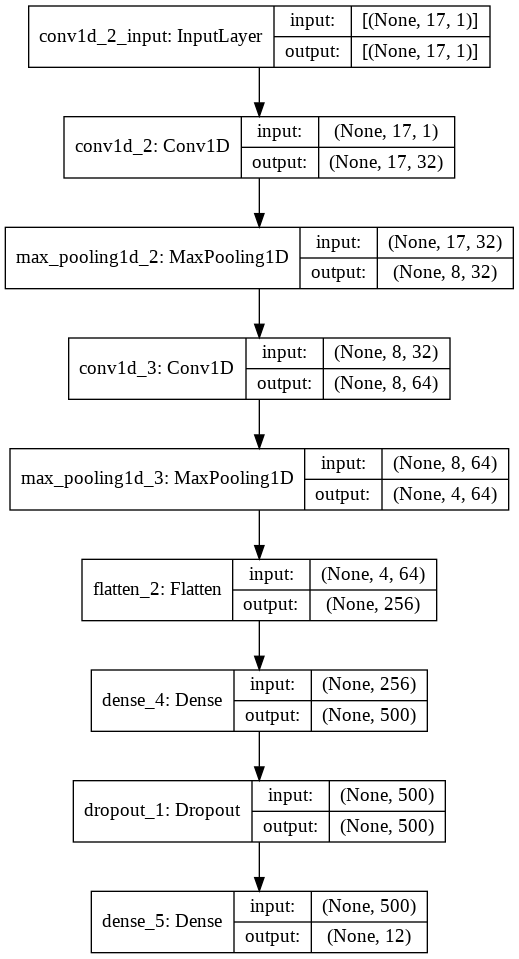

In [ ]:
cnn2 = keras.Sequential()
cnn2.add(keras.layers.Conv1D(32, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (17, 1)))
cnn2.add(keras.layers.MaxPooling1D(2))
cnn2.add(keras.layers.Conv1D(64, kernel_size = 2, padding = 'same', activation = 'relu'))
cnn2.add(keras.layers.MaxPooling1D(2))
cnn2.add(keras.layers.Flatten())
cnn2.add(keras.layers.Dense(500, activation = 'relu'))
cnn2.add(keras.layers.Dropout(0.4))
cnn2.add(keras.layers.Dense(12, activation = 'softmax'))
keras.utils.plot_model(cnn2, to_file = './pronto_cnn_alarm_architecture.png', show_shapes = True)

In [ ]:
cnn2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_cnn_alarm_model.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
cnn2_history = cnn2.fit(train_scaled2, train_target2, epochs = 100, validation_data = (val_scaled2, val_target2), callbacks = [checkpoint_cb, earlystopping_cb])

Epoch 1/100
909/909 [==============================] - 5s 5ms/step - loss: 1.0427 - accuracy: 0.6781 - val_loss: 1.0144 - val_accuracy: 0.6774
Epoch 2/100
909/909 [==============================] - 5s 5ms/step - loss: 1.0065 - accuracy: 0.6795 - val_loss: 0.9894 - val_accuracy: 0.6774
Epoch 3/100
909/909 [==============================] - 5s 6ms/step - loss: 0.9789 - accuracy: 0.6795 - val_loss: 0.9543 - val_accuracy: 0.6774
Epoch 4/100
909/909 [==============================] - 5s 6ms/step - loss: 0.9336 - accuracy: 0.6794 - val_loss: 0.9023 - val_accuracy: 0.6774
Epoch 5/100
909/909 [==============================] - 5s 6ms/step - loss: 0.8902 - accuracy: 0.6801 - val_loss: 0.9012 - val_accuracy: 0.6774
Epoch 6/100
909/909 [==============================] - 5s 5ms/step - loss: 0.8509 - accuracy: 0.6866 - val_loss: 0.8259 - val_accuracy: 0.6868
Epoch 7/100
909/909 [==============================] - 5s 6ms/step - loss: 0.8147 - accuracy: 0.6970 - val_loss: 0.7935 - val_accuracy: 0.6985

#### ANN

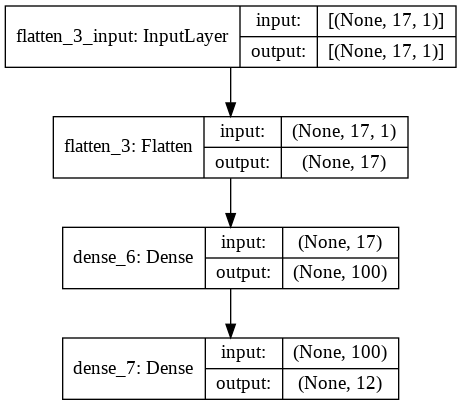

In [ ]:
ann2 = keras.Sequential()
ann2.add(keras.layers.Flatten(input_shape = (17, 1)))
ann2.add(keras.layers.Dense(100, activation = 'relu'))
ann2.add(keras.layers.Dense(12, activation = 'softmax'))
keras.utils.plot_model(ann2, to_file = './pronto_ann2_alarm_architecture.png', show_shapes = True)

In [ ]:
ann2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('./best_ann_alarm_model.h5')
earlystopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)
ann2_history = ann2.fit(train_scaled2, train_target2, epochs = 100, validation_data = (val_scaled2, val_target2), callbacks = [checkpoint_cb, earlystopping_cb])

Epoch 1/100
909/909 [==============================] - 2s 2ms/step - loss: 1.0639 - accuracy: 0.6698 - val_loss: 1.0200 - val_accuracy: 0.6774
Epoch 2/100
909/909 [==============================] - 1s 2ms/step - loss: 1.0182 - accuracy: 0.6795 - val_loss: 1.0222 - val_accuracy: 0.6774
Epoch 3/100
909/909 [==============================] - 1s 2ms/step - loss: 1.0135 - accuracy: 0.6795 - val_loss: 1.0117 - val_accuracy: 0.6774
Epoch 4/100
909/909 [==============================] - 2s 2ms/step - loss: 1.0089 - accuracy: 0.6795 - val_loss: 1.0067 - val_accuracy: 0.6774
Epoch 5/100
909/909 [==============================] - 1s 2ms/step - loss: 1.0021 - accuracy: 0.6795 - val_loss: 0.9996 - val_accuracy: 0.6774
Epoch 6/100
909/909 [==============================] - 2s 2ms/step - loss: 0.9935 - accuracy: 0.6795 - val_loss: 0.9945 - val_accuracy: 0.6774
Epoch 7/100
909/909 [==============================] - 2s 2ms/step - loss: 0.9880 - accuracy: 0.6795 - val_loss: 0.9867 - val_accuracy: 0.6774

### Reshape the data for Machine Learning

In [ ]:
train_scaled22 = train_scaled2.reshape(-1, 17)
val_scaled22 = val_scaled2.reshape(-1, 17)
print(train_scaled22.shape, val_scaled22.shape)

(29068, 17) (7268, 17)


#### Random Forest

In [ ]:
rf2 = RandomForestClassifier(n_jobs=-1, oob_score=True)
print(rf2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)


In [ ]:
rf2.fit(train_scaled22, train_target2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
rf2_train = rf2.score(train_scaled22, train_target2)
rf2_val = rf2.score(val_scaled22, val_target2) 
print(rf2_train, rf2_val)

1.0 0.9969730324711062


#### Support Vector machine

In [ ]:
svm2 = svm.LinearSVC(C = 1.0, max_iter = 10000)
svm2.fit(train_scaled22, train_target2)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
svm2_train = svm2.score(train_scaled22, train_target2)
svm2_val = svm2.score(val_scaled22, val_target2)
print(svm2_train ,svm2_val)

0.679475712123297 0.6773527793065492


In [ ]:
svm22 = svm.SVC(kernel = 'rbf', gamma = 0.7, C = 1.0)
svm22.fit(train_scaled22, train_target2)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.7, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm22_train = svm22.score(train_scaled22, train_target2)
svm22_val = svm22.score(val_scaled22, val_target2)
print(svm22_train, svm22_val)

0.679475712123297 0.6773527793065492


In [ ]:
svm23 = svm.SVC(kernel = 'poly', degree = 3, gamma = 'auto', C = 1.0)
svm23.fit(train_scaled22, train_target2)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm23_train = svm23.score(train_scaled22, train_target2)
svm23_val = svm23.score(val_scaled22, val_target2)
print(svm23_train, svm23_val)

0.679475712123297 0.6773527793065492


#### Logistic Regression

In [ ]:
lr2 = LogisticRegression(max_iter = 2000)
splitter = StratifiedKFold(n_splits= 5)
lr2_score = cross_validate(lr2, train_scaled22, train_target2, cv = splitter, return_train_score = True, return_estimator= True)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
print(np.mean(lr2_score['train_score']), np.mean(lr2_score['test_score']))

0.6794757122769187 0.6794757145813468


In [ ]:
lr21 = LogisticRegression(max_iter = 2000)
lr21.fit(train_scaled22,train_target2)
lr21_train = lr21.score(train_scaled22, train_target2)
lr21_val = lr21.score(val_scaled22, val_target2)

In [ ]:
print(lr21_train, lr21_val)

0.679475712123297 0.6773527793065492


## Test the models

In [ ]:
cnn1_score = cnn1.evaluate(test_scaled1, test_target1)
ann1_score = ann1.evaluate(test_scaled1, test_target1)
test_scaled11 = test_scaled1.reshape(-1, 28)
rf1_score = rf1.score(test_scaled11, test_target1)
svm1_score = svm1.score(test_scaled11, test_target1)
svm12_score = svm12.score(test_scaled11, test_target1)
svm13_score = svm13.score(test_scaled11, test_target1)
lr11_score = lr11.score(test_scaled11, test_target1)


284/284 [==============================] - 0s 1ms/step - loss: 0.3508 - accuracy: 0.8961


In [ ]:
cnn2_score = cnn2.evaluate(test_scaled2, test_target2)
ann2_score = ann2.evaluate(test_scaled2, test_target2)
test_scaled22 = test_scaled2.reshape(-1, 17)
rf2_score = rf2.score(test_scaled22, test_target2)
svm2_score = svm2.score(test_scaled22, test_target2)
svm22_score = svm22.score(test_scaled22, test_target2)
svm23_score = svm23.score(test_scaled22, test_target2)
lr21_score = lr21.score(test_scaled22, test_target2)

284/284 [==============================] - 0s 1ms/step - loss: 0.7390 - accuracy: 0.7372


## Visualize the result

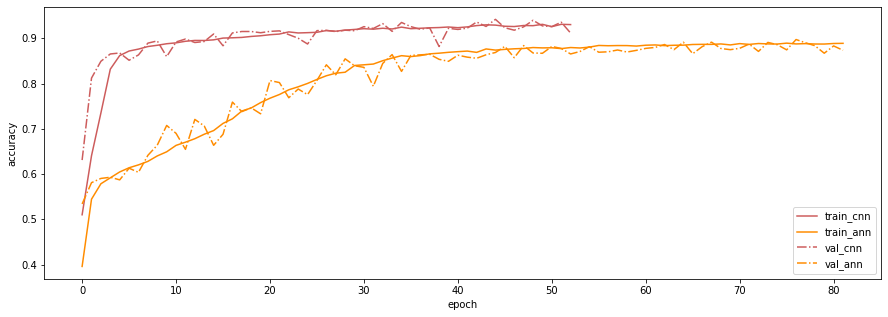

In [ ]:
color_map = ('indianred', 'darkorange', 'forestgreen', 'darkslateblue')
plt.figure(figsize = (15, 5))
plt.plot(cnn1_history.history['accuracy'], color = color_map[0], label = 'train_cnn')
plt.plot(ann1_history.history['accuracy'], color = color_map[1], label = 'train_ann')
plt.plot(cnn1_history.history['val_accuracy'], color = color_map[0], label = 'val_cnn', linestyle = '-.')
plt.plot(ann1_history.history['val_accuracy'], color = color_map[1], label = 'val_ann', linestyle = '-.')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('./PRONTO_failure_result.png')
plt.show()

In [ ]:
infile = open('./PRONTO_result.tsv', 'w')
infile.write('\tCNN \tANN \t Random Forest \t SVM(linear) \tSVM(rbf)\t SVM(poly)\t Logistic Regression\n')
infile.write('failure\n')
infile.write('train\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(statistics.mean(cnn1_history.history['accuracy']), statistics.mean(ann1_history.history['accuracy']), rf1_train, svm1_train, svm12_train, svm13_train, lr11_train))
infile.write('val\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(statistics.mean(cnn1_history.history['val_accuracy']), statistics.mean(ann1_history.history['val_accuracy']), rf1_val, svm1_val, svm12_val, svm13_val, lr11_val))
infile.write('test\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(cnn1_score[1], ann1_score[1], rf1_score, svm1_score, svm12_score, svm13_score, lr11_score))
infile.write('alarm\n')
infile.write('train\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(statistics.mean(cnn2_history.history['accuracy']), statistics.mean(ann2_history.history['accuracy']), rf2_train, svm2_train, svm22_train, svm23_train, lr21_train))
infile.write('val\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(statistics.mean(cnn2_history.history['val_accuracy']), statistics.mean(ann2_history.history['val_accuracy']), rf2_val, svm2_val, svm22_val, svm23_val, lr21_val))
infile.write('test\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(cnn2_score[1], ann2_score[1], rf2_score, svm2_score, svm22_score, svm23_score, lr21_score))
infile.close()